In [1]:
import sys
import os
sys.path.insert(0, '/mnt/EigeneDateien/Programmierung/head-tracking/3DDFA_V2/')

In [2]:
from importlib import reload
from os.path import join, splitext, sep, dirname
from collections import defaultdict
import sys
import numpy as np
import cv2
cv2.setNumThreads(1)
import os
import itertools
import h5py
from scipy.spatial.transform import Rotation
import zipfile
import io
import scipy.io
import tqdm
from PIL import Image
from IPython.display import display

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.functions import draw_landmarks
from utils.render import render
from utils.depth import depth
from utils.pose import viz_pose, calc_pose, P2sRt

In [5]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

In [6]:
def is_sample_file(fn):
    return splitext(fn)[1]=='.mat' and not fn.endswith(sep) \
        and dirname(fn)=='AFLW2000'

def discover_samples(zf):
    filenames = [ 
        f.filename for f in zf.filelist if is_sample_file(f.filename)  ]
    return filenames

def imdecode(blob, color=False):
    if isinstance(blob, bytes):
        blob = np.frombuffer(blob, dtype='B')
    img = cv2.imdecode(blob, cv2.IMREAD_COLOR if color else 0)
    assert img is not None
    if color == 'rgb':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Adapted from 
# https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.py
def box_iou(box1, box2):
    '''Compute the intersection over union of two set of boxes.
    The box order must be (xmin, ymin, xmax, ymax).
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
    Return:
      (tensor) iou, sized [N,M].
    Reference:
      https://github.com/chainer/chainercv/blob/master/chainercv/utils/bbox/bbox_iou.py
    '''
    lt = np.maximum(box1[:,None,:2], box2[:,:2])  # [N,M,2]
    rb = np.minimum(box1[:,None,2:], box2[:,2:])  # [N,M,2]

    wh = np.maximum(rb-lt, 0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

    area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
    area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
    iou = inter / (area1[:,None] + area2 - inter)
    return iou

def select_good_box(roi, boxes):
    # Of the those which face_boxes detected, pick the one
    # which has most overlap with the bounding box of the
    # key points.  But only if no other boxes overlap too much.
    aboxes = np.array([
        (x0, y0, x1, y1) for (x0, y0, x1, y1, c) in boxes if c > 0.5
    ])
    ious = box_iou(np.array([roi]), aboxes)
    ious = ious[0]
    idx, = np.where(ious > 0.5)
    if len(idx) != 1:
        return None
    else:
        return aboxes[idx[0]]


class AFLW2k3D(Dataset):
    def __init__(self, zipfilename, crop = 'center'):
        self.zipfilename = zipfilename
        with zipfile.ZipFile(zipfilename) as zf:
            self.matfilenames = sorted(discover_samples(zf))
        self.zipfile = None
        self.crop = crop
    
    def __len__(self):
        return len(self.matfilenames)

    def __getitem__(self, i):
        if self.zipfile is None:
            self.zipfile = zipfile.ZipFile(self.zipfilename)
        
        matfile = self.matfilenames[i]
        with io.BytesIO(self.zipfile.read(matfile)) as f:
            data = scipy.io.loadmat(f)

        assert all((k in data) for k in 'pt3d_68 Pose_Para'.split()), f"Data not found in file {matfile}. Contents is {data.keys()}"

        pt3d_68 = data['pt3d_68']
        
        jpgbuffer = self.zipfile.read(splitext(matfile)[0]+'.jpg')
        img = imdecode(jpgbuffer, color='rgb')

        pitch, yaw, roll, tx, ty, tz, scale = data['Pose_Para'][0]
        
        return img, (np.array([pitch, yaw, roll]), pt3d_68)

In [7]:
aflw2k3d = AFLW2k3D('/mnt/BigData/head-tracking-datasets/AFLW2000-3D.zip')

In [8]:
predicted = []
euler_rot_targets = []
indices = []
filtered = []
failures = []
rot_magnitude_errors = []

for i, (img, label) in enumerate(tqdm.tqdm(aflw2k3d)):
    euler_rot, pt3d_68 = label
    pose_para_degrees = euler_rot*180./np.pi

    # Following the img2pose paper
    if np.any(np.abs(pose_para_degrees) > 99):
        filtered.append((i, pose_para_degrees))
        continue        

    landmark_roi = [
        pt3d_68[0].min(),
        pt3d_68[1].min(),
        pt3d_68[0].max(),
        pt3d_68[1].max()
    ]

    # Taking the boxes from the face detector and skipping over failures where no faces were detected decreases the average MAE to 4.010°
    if 0:
        # Face detection
        boxes = face_boxes(img)
        if len(boxes) > 1:
            box = select_good_box(landmark_roi, boxes)
            if box is not None:
                boxes = [ box ]
            else:
                boxes = []
            # Commenting the following two lines makes the result only minimally worse:
            # MAE pitch: 5.286°, yaw: 3.390°, roll: 3.361°, average: 4.012°
            # In this case the box with the highest IOU with the bounding box of the landmarks is taken.
            failures.append(i)
            continue
        if not boxes:
            failures.append(i)
            continue
    else:
        boxes = [ landmark_roi ]

    pitch, yaw, roll = euler_rot
    rot_target = Rotation.from_euler('XYZ', [pitch,-yaw,roll])
        
    param_lst, roi_box_lst = tddfa(img, boxes)    
    f, R, t = P2sRt(param_lst[0][:12].reshape(3, -1))
    P = np.array([
        [ 1, 0,  0 ],
        [ 0, -1, 0 ],
        [ 0, 0,  1 ]
    ], dtype=np.float64)
    R = np.dot(P.T, np.dot(R, P))

    rot_magnitude_errors.append(
        (Rotation.from_matrix(R).inv()*rot_target).magnitude())
    
    pred_pitch, pred_yaw, pred_roll = Rotation.from_matrix(R).as_euler('XYZ')
    pred_yaw = -pred_yaw
    
    predicted.append(np.array([pred_pitch, pred_yaw, pred_roll]))
    euler_rot_targets.append(euler_rot)
    indices.append(i)

error_list = np.abs(np.array(predicted) - np.array(euler_rot_targets))
mae_euler = np.average(error_list, axis=0)*180./np.pi

print ("MAE pitch: {:0.3f}°, yaw: {:0.3f}°, roll: {:0.3f}°, average: {:0.3f}°".format(*mae_euler,np.average(mae_euler)))

100%|██████████| 2000/2000 [00:17<00:00, 114.80it/s]

MAE pitch: 5.227°, yaw: 3.183°, roll: 3.468°, average: 3.959°


In [9]:
np.average(rot_magnitude_errors)*180/np.pi

5.7816718188053775

In [10]:
iworst = np.argmax(np.average(error_list, axis=1))

In [11]:
print(predicted[iworst]*180./np.pi,'vs', euler_rot_targets[iworst]*180./np.pi)

[-119.20587714  -86.57417535  124.03394207] vs [-12.107419 -82.71608   15.846971]


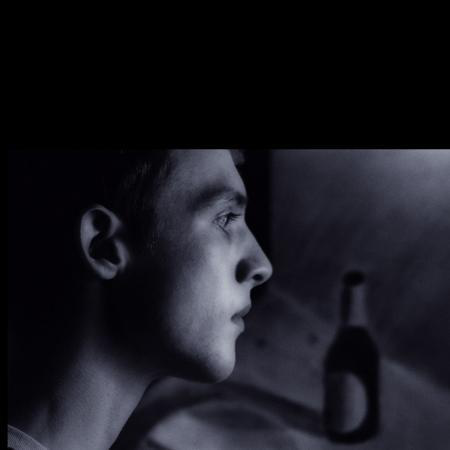

In [12]:
img = aflw2k3d[indices[iworst]][0]
display(Image.fromarray(img))
        

Failures due to the face detector

In [13]:
for i in failures:
    img = aflw2k3d[i][0]
    display(Image.fromarray(img).resize((128, img.shape[1]//img.shape[0]*128)))